In [1]:
import pandas as pd
import time
import numpy as np
import re
import pickle
import string, unicodedata
from unidecode import unidecode
from modulku import praproses as pps
from sklearn.decomposition import PCA

## Load Data

In [2]:
data = pd.read_excel('data/data_komentar_clean_1.xlsx', sheet_name = 'imbang')
komentar = data['komentar'].tolist()
label = data['label'].tolist()
kode = data['kode'].tolist()

#data untuk confusion matrix
data_ = pd.read_excel('data/data_komentar_clean_1.xlsx', sheet_name = 'cm_bal')
latih_cm = data_['komentar'].tolist()
label_cm = data_['label'].tolist()

## Seleksi Fitur

In [4]:
#proses membuat vocabularry
from sklearn.feature_extraction.text import TfidfVectorizer
kosa_kata = set()

###seleksi fitur
kk = TfidfVectorizer()
kk.fit_transform(komentar)
kosa_kata = kk.get_feature_names()
print(len(kosa_kata))
with open('model/feature_balance.txt', 'w') as f:
    for item in kosa_kata:
        f.write("%s\n" % item)

12467


## Proses TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
#membuat TF-IDF
f = open("model/feature_balance.txt")
kosa_kata = f.read().split()

tfidf = TfidfVectorizer(vocabulary = kosa_kata)
##Membuat Matrix TF-IDF
tfidf_matrix = tfidf.fit_transform(komentar)
X = tfidf_matrix.toarray()
Y = np.array(label)

#For confusion matrix
tfidf_matrix_ = tfidf.fit_transform(latih_cm) #For CM
print(tfidf_matrix.shape)
X_ = tfidf_matrix_.toarray()
Y_ = np.array(label_cm)
y = np.array(kode)

(3500, 12467)


## Plot Bar Label Dataset

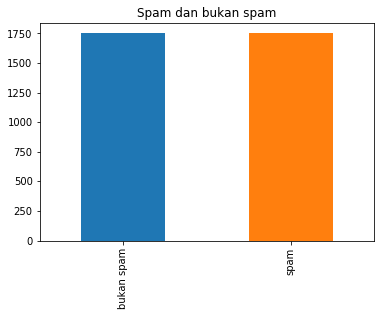

In [6]:

pca = PCA(n_components=2)
#X = pca.fit_transform(X)
pd.value_counts(data['label']).plot.bar(title='Spam dan bukan spam')
#pps.plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

In [19]:
len(Y_)

3001

## Proses Pemodelan

In [7]:
#Import Library
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB


### Input parameter

In [8]:
#parameter CNB
alpha = 0.18

#Parameter SVM
C = 1.8
gamma = 0.6

## K-Fold Cross Validation 
### jalanin aja dulu

In [9]:
K = 10 #pembagian data uji dan data latih
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score #, precision_score, recall_score
kf= KFold(n_splits=K) 

cSVM = svm.SVC(kernel='rbf', gamma=gamma, C=C)
comNB = ComplementNB(alpha = alpha)
clf = GaussianNB()

akurasi_svm = []
akurasi_cnb = []
akurasi_gnb = []

for train_index, test_index in kf.split(X):
    #membagi data latih dan data uji
    X_train, X_test = X[train_index], X[test_index] #pembagian data latih
    y_train, y_test = Y[train_index], Y[test_index]
    
    #Melatih Model 
    mSVM = cSVM.fit(X_train, y_train) #SVM
    mCNB = comNB.fit(X_train, y_train)
    mGNB = clf.fit(X_train, y_train)
            
    #proses prediksi
    P_SVM = mSVM.predict(X_test)
    P_CNB = mCNB.predict(X_test)
    P_GNB = mGNB.predict(X_test)
    
    #menyimpan hasil akurasi tiap iterasi
    akurasi_svm.append(accuracy_score(y_test, P_SVM))
    akurasi_cnb.append(accuracy_score(y_test, P_CNB))
    akurasi_gnb.append(accuracy_score(y_test, P_GNB))
    
rerata_akurasi_svm = sum(akurasi_svm)/len(akurasi_svm)
rerata_akurasi_cnb = sum(akurasi_cnb)/len(akurasi_cnb)
rerata_akurasi_gnb = sum(akurasi_gnb)/len(akurasi_gnb)


print("----------------------------------------")
print("Hasil K-Fold GNB")
print("   akurasi   :",round(rerata_akurasi_gnb,2))
print("----------------------------------------")
print("Hasil K-Fold CNB")
print("   akurasi   :",round(rerata_akurasi_cnb,2))
print("----------------------------------------")
print("Hasil K-Fold SVM")
print("   akurasi   :",round(rerata_akurasi_svm,2))


----------------------------------------
Hasil K-Fold GNB
   akurasi   : 0.88
----------------------------------------
Hasil K-Fold CNB
   akurasi   : 0.92
----------------------------------------
Hasil K-Fold SVM
   akurasi   : 0.92


# Confusion Matrix
## Proses Confusion Matrix untuk SVM

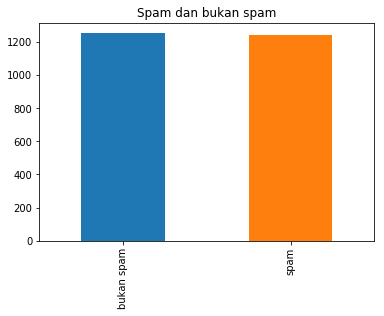

In [22]:
index_train = [x for x in range(500,3001)]
cm_Y = Y_[index_train]
dc = {"label":cm_Y}
cd = pd.DataFrame(dc, columns=['label'])
pd.value_counts(cd['label']).plot.bar(title='Spam dan bukan spam')

In [28]:
pd.value_counts(cd['label'])

bukan spam    1254
spam          1247
Name: label, dtype: int64

SVM
Confusion matrix, without normalization
[[246   4]
 [ 38 212]]


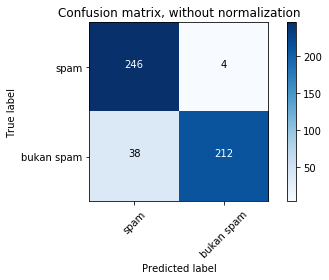

F-Measure (SVM)
----------------
akurasi   :  0.92
precision :  0.87
recall    :  0.98
f-Measure :  0.92
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
CNB
Confusion matrix, without normalization
[[243   7]
 [ 35 215]]


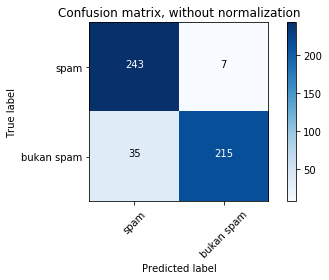

F-Measure (ComplementNB)
----------------
akurasi   :  0.92
precision :  0.87
recall    :  0.97
f-Measure :  0.92
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
GaussianNB
Confusion matrix, without normalization
[[209  41]
 [ 22 228]]


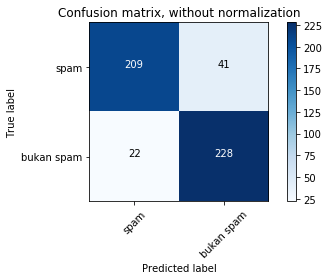

F-Measure (GaussianNB)
----------------
akurasi   :  0.88
precision :  0.9
recall    :  0.84
f-Measure :  0.87
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-


In [26]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm#, datasets
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Split the data into a training set and a test set
"""data uji sebanyak 1000 komentar, 500 komentar berlabel spam dan 500 komentar berlabel buka sapam"""
index_train = [x for x in range(500,3001)]
index__test = [x for x in range(500)]

cm_X = X_[index_train]
cm_Y = Y_[index_train]
cm_X_test = X_[index__test]
cm_Y_test = Y_[index__test]

X_train = cm_X
X_test = cm_X_test

y_train = cm_Y
y_test = cm_Y_test



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


    
class_names = ['spam', 'bukan spam']

classifier = svm.SVC(kernel='rbf', C=C, gamma=gamma)
y_pred = classifier.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
print("SVM")
cnf_matrix = confusion_matrix(y_test, y_pred) # inti
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      #title='Normalized confusion matrix')

plt.show()
# Menghitung F Measure
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
tp= round(cm [0][0],2)
fn= round(cm [0][1],2)
fp= round(cm [1][0],2)
tn= round(cm [1][1],2)
cm_akurasi = (tp+tn)/(tp+tn+fp+fn)
cm_precision = tp/(tp+fp)
cm_recall = tp/(tp+fn)

f_measure = 2*(cm_precision*cm_recall)/(cm_precision+cm_recall)
print("F-Measure (SVM)")
print("----------------")
print("akurasi   : ", round(cm_akurasi,2))
print("precision : ", round(cm_precision,2))
print("recall    : ", round(cm_recall,2))
print("f-Measure : ", round(f_measure,2))
print("+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-")

classifier = ComplementNB(alpha = .43)
y_pred = classifier.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
print("CNB")
cnf_matrix = confusion_matrix(y_test, y_pred) # inti
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      #title='Normalized confusion matrix')

plt.show()
# Menghitung F Measure
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
tp= round(cm [0][0],2)
fn= round(cm [0][1],2)
fp= round(cm [1][0],2)
tn= round(cm [1][1],2)
cm_akurasi = (tp+tn)/(tp+tn+fp+fn)
cm_precision = tp/(tp+fp)
cm_recall = tp/(tp+fn)

f_measure = 2*(cm_precision*cm_recall)/(cm_precision+cm_recall)
print("F-Measure (ComplementNB)")
print("----------------")
print("akurasi   : ", round(cm_akurasi,2))
print("precision : ", round(cm_precision,2))
print("recall    : ", round(cm_recall,2))
print("f-Measure : ", round(f_measure,2))
print("+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-")

classifier = GaussianNB()
y_pred = classifier.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
print("GaussianNB")
cnf_matrix = confusion_matrix(y_test, y_pred) # inti
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      #title='Normalized confusion matrix')

plt.show()
# Menghitung F Measure
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
tp= round(cm [0][0],2)
fn= round(cm [0][1],2)
fp= round(cm [1][0],2)
tn= round(cm [1][1],2)
cm_akurasi = (tp+tn)/(tp+tn+fp+fn)
cm_precision = tp/(tp+fp)
cm_recall = tp/(tp+fn)

f_measure = 2*(cm_precision*cm_recall)/(cm_precision+cm_recall)
print("F-Measure (GaussianNB)")
print("----------------")
print("akurasi   : ", round(cm_akurasi,2))
print("precision : ", round(cm_precision,2))
print("recall    : ", round(cm_recall,2))
print("f-Measure : ", round(f_measure,2))
print("+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-")

In [10]:
plt.show()

## Proses Confusion Matrix untuk CNB

Confusion matrix, without normalization
[[241   9]
 [ 34 216]]
Normalized confusion matrix
[[0.96 0.04]
 [0.14 0.86]]


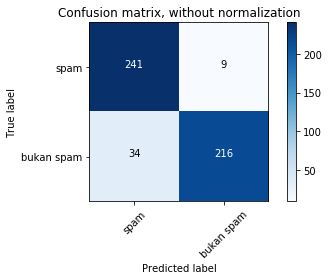

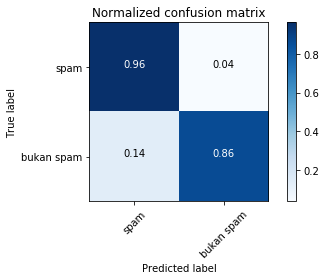

F-Measure (CNB)
----------------
akurasi   :  0.91
precision :  0.88
recall    :  0.96
f-Measure :  0.92


In [23]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# import some data to play with
class_names = ['spam', 'bukan spam']

# Split the data into a training set and a test set
index_train = [x for x in range(500,3001)]
index__test = [x for x in range(500)]

cm_X = X_[index_train]
cm_Y = Y_[index_train]

cm_X_test = X_[index__test]
cm_Y_test = Y_[index__test]

X_train = cm_X
X_test = cm_X_test
y_train = cm_Y
y_test = cm_Y_test

classifier = ComplementNB(alpha = .38)
y_pred = classifier.fit(X_train, y_train).predict(X_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Menghitung F Measure

cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
tp= round(cm [0][0],4)
fn= round(cm [0][1],4)
fp= round(cm [1][0],4)
tn= round(cm [1][1],4)
cm_akurasi = (tp+tn)/(tp+tn+fp+fn)
cm_precision = tp/(tp+fp)
cm_recall = tp/(tp+fn)

f_measure = 2*(cm_precision*cm_recall)/(cm_precision+cm_recall)
print("F-Measure (CNB)")
print("----------------")
print("akurasi   : ", round(cm_akurasi,2))
print("precision : ", round(cm_precision,2))
print("recall    : ", round(cm_recall,2))
print("f-Measure : ", round(f_measure,2))

## Menyimpan model

In [34]:
cSVM = svm.SVC(kernel='rbf', gamma=gamma, C=C)
comNB = ComplementNB(alpha = alpha)
#Melatih Model untuk data secara keseluruhan (X dan Y)
cSVM = cSVM.fit(X, Y) #SVN
comNB = comNB.fit(X, Y) #CNB

#save models
filename = 'model\cSVM.sav'
pickle.dump(cSVM, open(filename, 'wb'))
filename = 'model\comNB.sav'
pickle.dump(comNB, open(filename, 'wb'))

In [41]:
print(" "*90000)

##  komentar baru

In [ ]:
from modulku import preproses
#preproses.stemmer_stopWord("atau memakan nasi")

In [36]:
t_komentar = ["" for x in range (3800)]
#input_komentar = "Cek IG kami Kak, solusiii naiiikkk tinggiiii sampe 175cm, bahkan sampe umuur 33th masih bisa looh, Buruaaaaannn. '"
input_komentar = input("Komentar: ")
#komentar  = [cleaning2(input_komentar)]
komentar0 = preproses.preprocessing(input_komentar)
komentar_ = preproses.removePunc(komentar0)
komentar_ = preproses.stemmer_stopWord(komentar_)
t_komentar[-1]=komentar_
print("==============================================================================================================================")
print(komentar0)
print("==============================================================================================================================")

#t_clean_komentar_hapus = komentar_akhir
#komentar_siap = []
#komentar_siap.append(komentar)
#vocabulary = koso_kata
t_tfidf_matrix = tfidf.fit_transform(t_komentar)

data_X = t_tfidf_matrix.toarray()
#cek 
#x_cek = data_X[len(t_clean_komentar_hapus)-1:len(t_clean_komentar_hapus)]
x_cek = data_X[len(t_komentar)-1:len(t_komentar)]
#x_cek = data_X[-1]

# prediksi data asli
P_SVM = cSVM.predict(x_cek)
P_NB = comNB.predict(x_cek)

# print prediksi
print("Prediksi SVM (TF-IDF)           : ", P_SVM)
print("Prediksi C Naive Bayes (TF-IDF) : ", P_NB)
print(t_tfidf_matrix.shape)


Komentar: MÁŚĶĔŔ ŴÁĴÁĤŃŶÁ oĶĔ ßÁŃĞĔŤ ĶÁĶ ŚĔĶÁŔÁŃĞ ŴÁĴÁĤĶÚ ĞÁK ĶÚŚÁMMMM ĹÁĞĨIIIII MÁĶÁŚĨĤH#@DR.KEYSA.FASHIONHERBAL 😍😍 ßÁŔÚ PÁĶĔ 2MĨŃĞĞÚ ÚĎÁĤ ĶĔĹĨÁŤÁŃ PĔŔÚßÁĤÁŃŃŶÁ ŴÁĴÁĤ ÁĶÚ ĴÚĞÁ ĴÁĎĨ ĶĔŃČĔŃĞ ĞÁ ĶĔĹĨÁŤÁŃ ĶĔŔĨPÚŤ ĹÁĞĨ hehe 💖💖💖
masker wajahnya oke banget kak sekarang wajahku gak kusammmm lagiiiiii makasihh @dr.keysa.fashionherbal baru pake 2minggu udah keliatan perubahannya wajah aku juga jadi kenceng ga keliatan keriput lagi hehe
Prediksi SVM (TF-IDF)           :  ['spam']
Prediksi C Naive Bayes (TF-IDF) :  ['spam']
(3800, 13065)


## Prediksi komentar baru lebih dari satu komentar

In [8]:
input_ = pd.read_excel("coba prediksi.xlsx") #memasukkan nama file excel berisi komentar baru (yang akan di cek)


input_list = input_['komentar'].tolist()
f_komentar = ["" for x in range (3800)]
list_komentar = input_list
join_komentar = preproses.preprocessing_implentasi(list_komentar) + f_komentar
print("*")
kokom = join_komentar[:3800]
f = open("model/feature.txt") 
voc = f.read().split()
t_tfidf = TfidfVectorizer(vocabulary = voc)
t_tfidf_matrix = tfidf.fit_transform(kokom)
cek_komentar = t_tfidf_matrix[:len(list_komentar)]
cek_komentar = cek_komentar.toarray()

#melakukan prediksi untuk komentar baru
P_SVM = cSVM.predict(cek_komentar)
P_NB = comNB.predict(cek_komentar)


dict = {'komentar':input_list, "prediksi svm":P_SVM, "prediksi CNB": P_NB}
df = pd.DataFrame(dict, columns=['komentar',"prediksi svm","prediksi CNB"])
df

*


NameError: name 'TfidfVectorizer' is not defined

In [98]:
df

,komentar,prediksi svm,prediksi CNB
0,Assalamualaikum wr.wb..!!!*PROMO BIG SALE 2018...,spam,spam
1,yg msh kangen momen2 asian games bisa klik lin...,spam,spam
2,ok klau begitu saya coba pake panelpediavip.co...,spam,spam
3,Ғollowwww IG @Marcella.beauty_specialist gaaa...,spam,spam
4,Moga lancar n sukses y kak via besuk sore diko...,bukan spam,bukan spam
5,Semingguuu yang laluuuu akuuu cobaaa cekkk ins...,spam,spam
6,THÀNKSSSSSS ÝÀ KÀK ÚDÀHHHHHHHH KÀSÌHHHHHHHH TÀ...,spam,spam
7,MÁŚĶĔŔ ŴÁĴÁĤŃŶÁ oĶĔ ßÁŃĞĔŤ ĶÁĶ ŚĔĶÁŔÁŃĞ ŴÁĴÁĤĶ...,spam,spam
8,"ÀJÀÌBBBBBBBBB ρRÓDÚKNÝÀÀÀÀÀÀ KÀK , BÀNÝÀKKKKK ...",spam,spam
